# Starting the Ammonia Kinematics Project

To start, I'll just import a bunch of the packages that I know I'll need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
import pickle
import math
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

Next let's open up the velocity 1 posterior file. This gives a probability distribution funciton showing the probability that the ammonia gas is at each velocity. (From Brian Svoboda)

In [2]:
path = 'v1_voff_post.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

wcs_velocities = wcs.WCS(header)
print(wcs_velocities)
print(data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                  199                                                  CDELT1  =      -0.001666666707                                                  CDELT2  =       0.001666666707                                                  CRPIX1  =               1100.0                                                  CRPIX2  =               9785.0                                                  CRVAL1  =        170.233333333                                                  CRVAL2  =                  0.0                                                  CTYPE1  = 'GLON-SFL'                    

Next, we define the velocity channels and plot a single random pixel to see what the probability distributions look like. Then we go through pixel by pixel and take the highest probability velocity at each pixel and save them to a grid system to plot in a map. We still need to go through and save this to a new .fits file for Megan. The same code can also be used for any of the other posterior distributions (assuming the file is opened and the variable names are changed), which I have previously done for the linewidths and the column density.

Velocity Resolution: 0.020100486924400585 kms
0.000559298
0.0693021
5.094974102757829
(800, 2200)


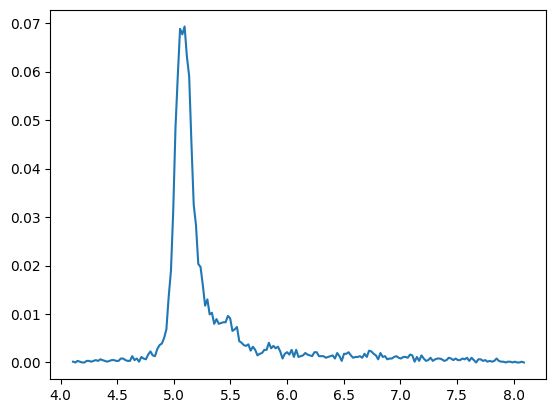

In [3]:
vel_start = header["CRVAL3"]
vel_inc = header["CDELT3"]

v_channels = np.arange(header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

print('Velocity Resolution:', velocity[1]-velocity[0], 'kms')

posterior_dist = data[:, 75, 1400]

plt.plot(velocity, posterior_dist)
print(np.std(posterior_dist[100:190]))

print(np.max(posterior_dist))
print(velocity[list(posterior_dist).index(np.max(posterior_dist))])

image = data[:, :, :]
max_post = np.max(data[:, :, :], axis = 0)
print(max_post.shape)

velocity_grid = []
for i in range(800):
    row_number = []
    for j in range(2200):
        posterior_dist = data[:, i, j]
        if math.isnan(max_post[i, j]):
            row_number.append(max_post[i,j])
        else:
            row_number.append(velocity[list(posterior_dist).index(max_post[i, j])])
    velocity_grid.append(row_number)

Now we plot that grid in galactic coordinates.

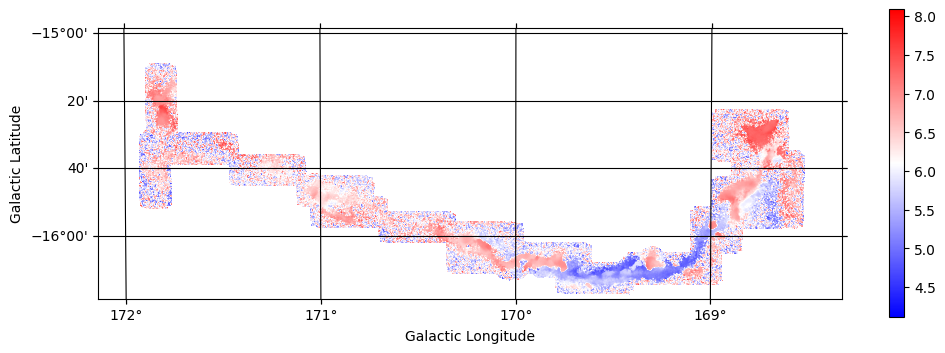

In [5]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
plt.imshow(velocity_grid, origin = 'lower', cmap = 'bwr')
plt.colorbar()
plt.grid()

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

Now save the maximum likelihood velocity map as a new fits file, which we cane open and work with later.

In [6]:
output_hdu = wcs_velocities.to_fits()
output_hdu[0].data is None

output_hdu[0].data = velocity_grid

output_hdu.writeto("velocity_grid.fits", overwrite=True)

Make subregions of the velocities to be analyzed on smaller scaled and the column densities (for Hanga and Hannah's research projects).

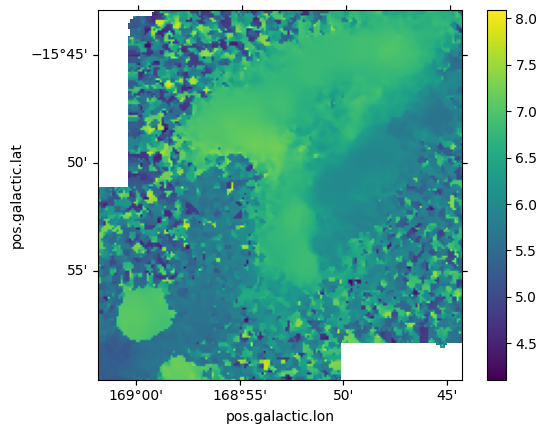

In [7]:
l_ll, b_ll = 169.03, -16.00
l_ur, b_ur = 168.74, -15.715

(xmin, ymin, vel), (xmax, ymax, vel) = wcs_velocities.wcs_world2pix([[l_ll, b_ll, 5.094974102757829], [l_ur, b_ur, 5.094974102757829]], 0)
(xmin, ymin, vel), (xmax, ymax, vel)

ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
im = ax.imshow(velocity_grid)
plt.colorbar(im)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

xmin_int, xmax_int = int(np.floor(xmin)), int(np.ceil(xmax))
ymin_int, ymax_int = int(np.floor(ymin)), int(np.ceil(ymax))

subregion = data[0:199, ymin_int:ymax_int,xmin_int:xmax_int]

slices = (slice(0, 199), slice(ymin_int, ymax_int), slice(xmin_int, xmax_int))

new_wcs = wcs_velocities.slice(slices)

#output_hdu = new_wcs.to_fits()
#output_hdu[0].data = subregion
#output_hdu.writeto("B10_ML_Column_Density.fits", overwrite=True)

Now let's open up the file 

In [11]:
path = 'HGBS_tauN3_skeleton_map.fits.gz'
cube = fits.open(path)
skeleton_data = cube[0].data
header = cube[0].header
print(header)

wcs_skeleton = wcs.WCS(header)
print(wcs_skeleton)
print(data.shape)

SIMPLE  =                    T / Written by IDL:  Tue Jan 15 09:47:57 2019      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    2 / Number of data axes                            NAXIS1  =                 8500 /Number of positions along axis 1                NAXIS2  =                 7200 /Number of positions along axis 2                CTYPE1  = 'RA---TAN'           / Coordinate Type                                CTYPE2  = 'DEC--TAN'           / Coordinate Type                                EQUINOX =                 2000 /Equinox of Ref. Coord.                          CDELT1  =         -0.000833333 / Degrees / Pixel                                CDELT2  =          0.000833333 / Degrees / Pixel                                CROTA2  =              0.00000 / Rotation Angle (Degrees)                       CRPIX1  =            4250.5000 / Reference Pixel in X                           CRPIX2  =            3600.5000 / Referen

/tmp/ipykernel_3750963/618568361.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')


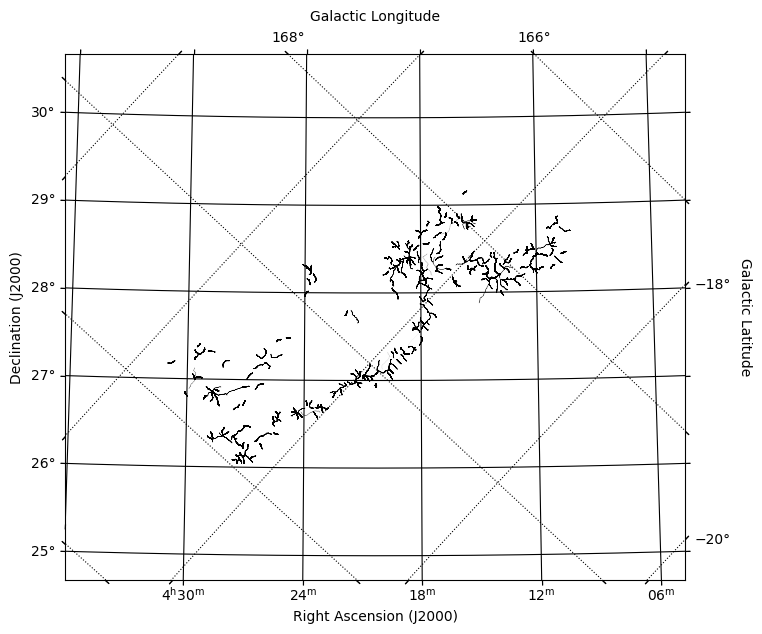

In [12]:
plt.figure(figsize = [8, 10])

ax = plt.subplot(projection=wcs_skeleton, slices=('x', 'y'))
cm = plt.cm.get_cmap('Grays')
ax.imshow(skeleton_data, origin = 'lower', cmap = cm, vmin = 0, vmax = 0.9)

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')

In [13]:
coordinates = []
for i in range(1, 267):
    #print(len(np.argwhere(data[:, :] == i)))
    coordinates.append(np.argwhere(skeleton_data[:, :] == i))

In [14]:
coordinates_x = []
coordinates_y = []
for k in range(len(coordinates)):
    coordinates_i_x = []
    coordinates_i_y = []
    for i in range(len(coordinates[k])):
        coordinates_i_x.append(coordinates[k][i][0])
        coordinates_i_y.append(coordinates[k][i][1])
    coordinates_x.append(coordinates_i_x)
    coordinates_y.append(coordinates_i_y)
    
#plt.scatter(coordinates_264_x, coordinates_264_y)

In [16]:
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
coordinates_ra = []
coordinates_dec = []
coordinates_l = []
coordinates_b = []
for i in range(len(coordinates)):
    (x, y) = wcs_skeleton.wcs_pix2world(coordinates_y[i], coordinates_x[i], 0)
    #print(min(y), max(y))
    
    skeleton_i = SkyCoord(ra = x * u.deg, dec = y * u.deg, frame='icrs')
    
    galactic_coords = skeleton_i.transform_to(Galactic())
    l = []
    b = []
    for j in range(len(galactic_coords)):
        l.append(galactic_coords.l[j].degree)
        b.append(galactic_coords.b[j].degree)
    
    #print(np.min(b), np.max(b))
    c = SkyCoord(l, b, frame='galactic', unit='deg')
    pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_velocities, origin=1)
    
    coordinates_l.append(pixels_x)
    coordinates_b.append(pixels_y)
    #coordinates_b.append(-1*(pixels_y - 750) + 500)
    coordinates_ra.append(x)
    coordinates_dec.append(y)

/tmp/ipykernel_3750963/3897529067.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Grays')


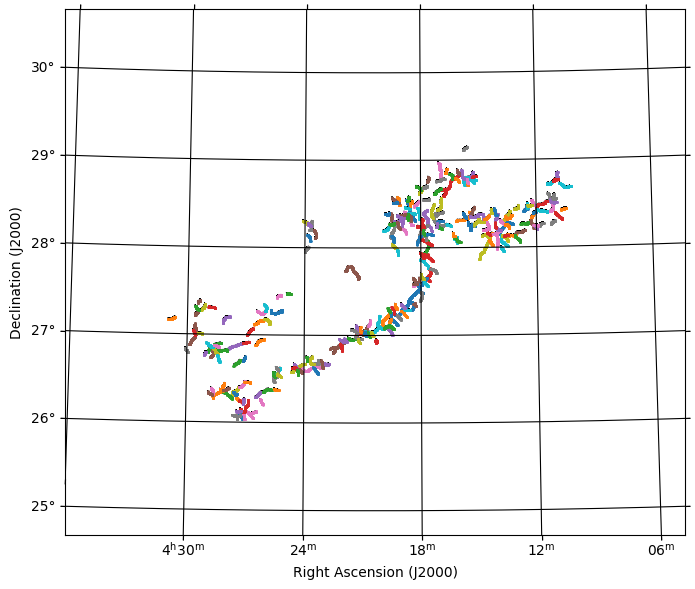

In [17]:
plt.figure(figsize = [8, 10])

ax = plt.subplot(projection=wcs_skeleton, slices=('x', 'y'))
cm = plt.cm.get_cmap('Grays')
ax.imshow(skeleton_data, origin = 'lower', cmap = cm, vmin = 0, vmax = 0.9)

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')

for i in range(len(coordinates)):
    plt.scatter(coordinates_y[i], coordinates_x[i], s = 1)

/tmp/ipykernel_3750963/3527271816.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


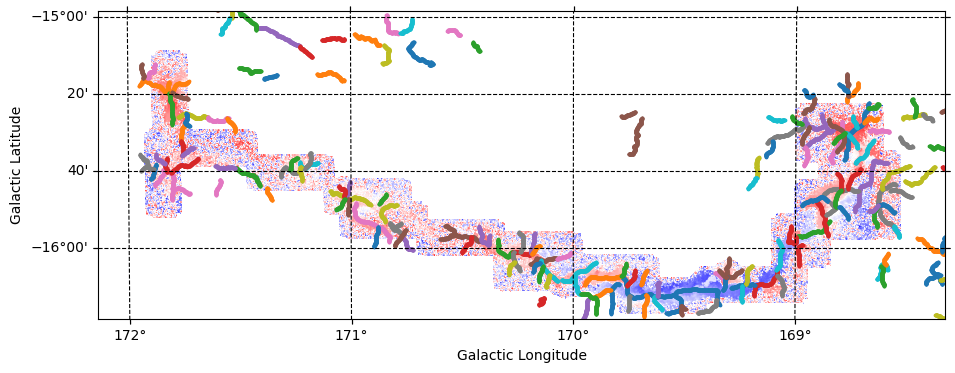

In [18]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
ax.imshow(velocity_grid, origin = 'lower', cmap = cm)
for i in range(len(coordinates)):
    ax.scatter(coordinates_l[i], coordinates_b[i], s = 3)

plt.grid()
plt.xlim(0, 2200)
plt.ylim(0, 800)

ax.coords.grid(True, color='black', ls='dashed')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

In [19]:
path = 'velocity_grid.fits'
cube = fits.open(path)
velocity_grid_data = cube[0].data
header = cube[0].header
#print(header)

wcs_vel_grid = wcs.WCS(header)
print(velocity_grid_data.shape)

vel_coords = np.argwhere(velocity_grid_data[:, :] != math.nan)

print(len(vel_coords))
print(vel_coords[2])

(800, 2200)
1760000
[0 2]


In [66]:
indices = []
for i in range(len(coordinates)):
    avg_x = np.nanmean(coordinates_l[i])
    avg_y = np.nanmean(coordinates_b[i])
    
    if avg_x > 2100 or avg_y > 705:
        continue
    else:
        indices.append(i)
    if 1800 < avg_x < 1900:
        print(i, avg_x, avg_y)
    else:
        continue

removed = [15, 17, 20, 42, 51, 78, 79, 82, 91, 104, 105, 122, 124, 128, 129, 149, 160, 167, 172, 173, 176, 191, 195, 230, 233, 240, 241, 251, 260]

for i in removed:
    indices.remove(i)

#print(len(indices))
print(indices)

#51, 20, 21

32 1862.396286992151 226.8373385602771
33 1882.2543858389104 262.9078983158798
34 1874.2954892292796 471.01749653754854
53 1800.4679195667013 210.5595305420571
60 1861.6291630121927 306.6678991636187
75 1849.136582869108 552.7703805093224
84 1855.5975714630608 500.1638294304845
103 1819.7578201976105 167.89526557398418
126 1838.8099782366792 421.52906483743675
154 1886.9040947388685 505.8091184057795
155 1835.6696942155957 476.4494506076302
222 1812.196823022188 513.1296732477882
230 1843.2444177770046 582.3911346857406
[0, 1, 2, 4, 6, 7, 16, 18, 19, 21, 23, 25, 27, 28, 30, 32, 33, 34, 35, 36, 40, 43, 44, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 62, 63, 64, 67, 69, 70, 75, 77, 83, 84, 86, 89, 90, 97, 101, 102, 103, 107, 111, 116, 117, 123, 125, 126, 127, 130, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 147, 153, 154, 155, 157, 161, 162, 163, 174, 175, 180, 181, 185, 186, 189, 190, 192, 193, 199, 202, 203, 204, 205, 208, 210, 212, 214, 215, 216, 217, 219, 220, 221, 222, 22

/tmp/ipykernel_3750963/2678488857.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


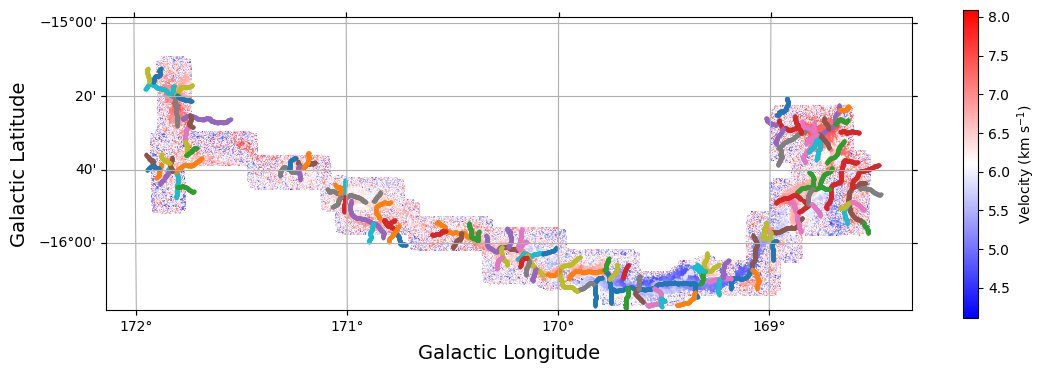

In [75]:
plt.figure(figsize = [13,4])
ax = plt.subplot(projection=wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
vel_map = ax.imshow(velocity_grid, origin = 'lower', cmap = cm)
for i in indices:
    ax.scatter(coordinates_l[i], coordinates_b[i], s = 3)

plt.grid()
plt.colorbar(vel_map, label = r'Velocity (km s$^{-1}$)')
plt.xlim(0, 2200)
plt.ylim(0, 800)

ax.coords.grid()
ax.coords[0].set_axislabel('Galactic Longitude', fontsize = 14)
ax.coords[1].set_axislabel('Galactic Latitude', fontsize = 14)
plt.savefig('velocity_map_spines.png', transparent=True, bbox_inches = 'tight')

In [ ]:
saved_l = []
saved_b = []
for i in indices:
    saved_l.append(coordinates_l[i])
    saved_b.append(coordinates_b[i])

df = pd.DataFrame(data={'Galactic Longitude': saved_l,
                        'Galactic Latitude': saved_b, 
                        'Identification': indices})

display(df)

with open('spines_coordinates.pkl', 'wb') as f:  # open a text file
    pickle.dump(df, f) # serialize the list
f.close()